Correlation between Height and Width: -0.8570148287860286, p-value: 0.0


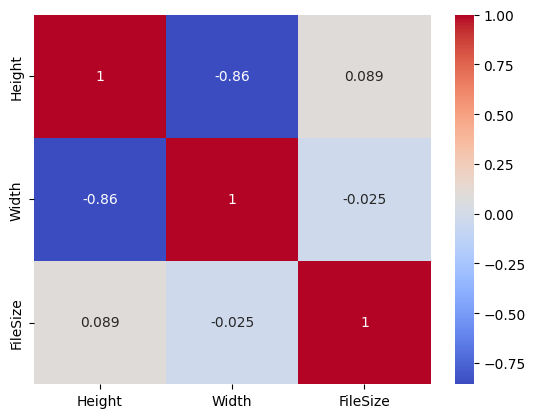

In [97]:
import numpy as np
import pandas as pd
import os
import cv2
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import pearsonr

# fonction pour extraire les caractéristiques des images
def get_image_features(image_dir):
    heights = []
    widths = []
    file_sizes = []

    for root, _, files in os.walk(image_dir):
        for file in files:
            if file.endswith(('.png', '.jpg', '.jpeg')):
                file_path = os.path.join(root, file)
                image = cv2.imread(file_path)
                if image is None:
                    continue
                h, w, _ = image.shape
                heights.append(h)
                widths.append(w)
                file_sizes.append(os.path.getsize(file_path))

    return heights, widths, file_sizes

image_dir = './data/raw'
heights, widths, file_sizes = get_image_features(image_dir)

df = pd.DataFrame({
    'Height': heights,
    'Width': widths,
    'FileSize': file_sizes
})

# calcul le coefficient de corrélation de Pearson
correlation, p_value = pearsonr(df['Height'], df['Width'])
print(f"Correlation between Height and Width: {correlation}, p-value: {p_value}")

# utilisation de seaborn pour afficher la matrice de corrélation
sns.heatmap(df.corr(), annot=True, cmap='coolwarm')
plt.show()


In [86]:
# Eliminer les données abérrantes
from scipy import stats

z_scores = np.abs(stats.zscore(df))
filtered_entries = (z_scores < 3).all(axis=1)
df_clean = df[filtered_entries]

print(f"Nombre de données d'origine: {df.shape[0]}, Nombre de données après le nettoyage: {df_clean.shape[0]}")


Nombre de données d'origine: 1756, Nombre de données après le nettoyage: 1701


In [87]:
# Augmenter les données
from keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Générer des images augmentées
for batch in datagen.flow_from_directory(image_dir, batch_size=55, save_to_dir='data', save_prefix='aug', save_format='jpg'):
    print('Batch shape:', batch[0].shape)  
    print(f"Number of images generated: {len(batch[0])}")
    break


Found 1756 images belonging to 3 classes.
Batch shape: (55, 256, 256, 3)
Number of images generated: 55


In [88]:
# Splitter le corpus en test et train
from sklearn.model_selection import train_test_split

image_paths = [os.path.join(root, file) for root, _, files in os.walk(image_dir) for file in files if file.endswith(('.png', '.jpg', '.jpeg'))]
train_paths, test_paths = train_test_split(image_paths, test_size=0.2, random_state=42)

print(f"Nombre d'images de train: {len(train_paths)}, Nombre d'images de test: {len(test_paths)}")


Nombre d'images de train: 1404, Nombre d'images de test: 352


In [89]:
import pandas as pd
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

data_dir = './data/raw'  
csv_file = './data/dog_breeds_images.csv'  
df = pd.read_csv(csv_file)

def load_images(dataframe):
    images = []
    labels = []
    for index, row in dataframe.iterrows():
        img_path = row['image']  
        if not os.path.exists(img_path):
            print(f"File not found: {img_path}")
            continue
        img = tf.keras.preprocessing.image.load_img(img_path, target_size=(28, 28), color_mode='grayscale')
        img = tf.keras.preprocessing.image.img_to_array(img) / 255.0
        images.append(img)
        labels.append(row['label'])
    return np.array(images), np.array(labels)

X, y = load_images(df)



In [90]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense



y = to_categorical(y)

X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.25, random_state=42) 

model = Sequential([
    Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(28, 28, 1)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.25),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(y_train.shape[1], activation='softmax')
])

model.compile(loss='categorical_crossentropy', optimizer='Adam', metrics=['accuracy'])

history = model.fit(X_train, y_train, epochs=10, validation_data=(X_val, y_val))


Epoch 1/10
33/33 [==============================] - 1s 21ms/step - loss: 1.0195 - accuracy: 0.4444 - val_loss: 0.8192 - val_accuracy: 0.6068
Epoch 2/10
33/33 [==============================] - 1s 18ms/step - loss: 0.7722 - accuracy: 0.6078 - val_loss: 0.7275 - val_accuracy: 0.6524
Epoch 3/10
33/33 [==============================] - 1s 17ms/step - loss: 0.6886 - accuracy: 0.6686 - val_loss: 0.6733 - val_accuracy: 0.6866
Epoch 4/10
33/33 [==============================] - 1s 17ms/step - loss: 0.6318 - accuracy: 0.7142 - val_loss: 0.6328 - val_accuracy: 0.7094
Epoch 5/10
33/33 [==============================] - 1s 16ms/step - loss: 0.5494 - accuracy: 0.7778 - val_loss: 0.5952 - val_accuracy: 0.7094
Epoch 6/10
33/33 [==============================] - 1s 16ms/step - loss: 0.4823 - accuracy: 0.7844 - val_loss: 0.6204 - val_accuracy: 0.7066
Epoch 7/10
33/33 [==============================] - 1s 16ms/step - loss: 0.4149 - accuracy: 0.8357 - val_loss: 0.5940 - val_accuracy: 0.7265
Epoch 8/10
33

In [91]:
# evaluation du modèle
predictions = model.predict(X_val)
y_pred = np.argmax(predictions, axis=1)
y_true = np.argmax(y_val, axis=1)

# classification report et confusion matrix
report = classification_report(y_true, y_pred)
matrix = confusion_matrix(y_true, y_pred)

print("Classification Report:\n", report)


11/11 [==============================] - 0s 3ms/step
Classification Report:
               precision    recall  f1-score   support

           0       0.80      0.75      0.77       131
           1       0.78      0.79      0.78       135
           2       0.87      0.92      0.89        85

    accuracy                           0.81       351
   macro avg       0.81      0.82      0.82       351
weighted avg       0.81      0.81      0.81       351



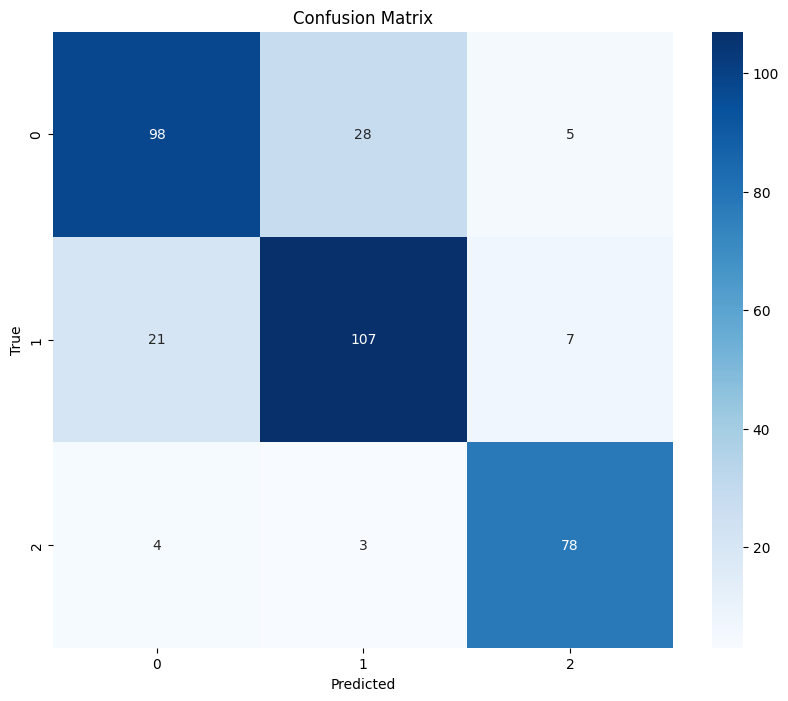

In [92]:
# affichage de la matrice de confusion
def plot_confusion_matrix(cm, class_labels):
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_labels, yticklabels=class_labels)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()

class_labels = list(df['label'].unique())
plot_confusion_matrix(matrix, class_labels)

In [95]:
# efficacité du modèle
model.save('model.keras', save_format='keras')

model_size = os.path.getsize('model.keras') / (1024 ** 2)  # 以MB为单位
print(f"Model Size: {model_size:.2f} MB")

sample_input = np.random.rand(1, 28, 28, 1)

num_iterations = 100
start_time = time.time()
for _ in range(num_iterations):
    _ = model.predict(sample_input)
end_time = time.time()

average_inference_time = (end_time - start_time) / num_iterations
print(f"Average Inference Time: {average_inference_time:.6f} seconds")

Model Size: 4.60 MB
1/1 [==============================] - 0s 12ms/step
Average Inference Time: 0.030190 seconds
